In [6]:
import zipfile
import os

import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers

In [7]:
## Data link: https://drive.google.com/file/d/1WzHYYXIdgLh7BDbELX69JwL9ZGCMd0qp/view?usp=sharing

file = zipfile.ZipFile('data.zip')
file.extractall()
file.close()

In [8]:
training_path = 'images/train'
validation_path = 'images/validation'

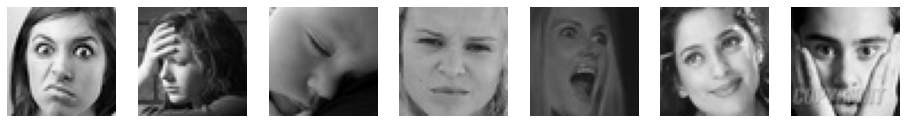

Image shape:  (48, 48, 3)
Total training images:  28821
Total validation image:  7066


In [9]:
## Printing the image from each expression
plt.figure(figsize= (16, 8))
shape = None
total_size = 0
for i, file_name in enumerate(os.listdir(training_path)):
    plt.subplot(1, 7, i+1)
    image_path = os.listdir(os.path.join(training_path, file_name))
    total_size += len(image_path)
    img = cv.imread(training_path + '/'+file_name+'/'+image_path[0])
    plt.imshow(img)
    shape = img.shape
    plt.axis('off')
plt.show()

total_val_size = 0
for i, file_name in enumerate(os.listdir(validation_path)):
    image_path = os.listdir(os.path.join(validation_path, file_name))
    total_val_size += len(image_path)

print("Image shape: ", shape)
print("Total training images: ", total_size)
print("Total validation image: ", total_val_size)

In [10]:
## Image generator

train_gen = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip = True,
    rescale = 1.0/255.0
)

test_gen = ImageDataGenerator(rescale = 1.0/255.0)

In [12]:
## Fetching the image from the directory using image data generator

batch_size = 64
steps = np.ceil(total_size/batch_size)

train = train_gen.flow_from_directory(
    training_path, 
    target_size = (48, 48),
    batch_size = batch_size,
)

val_steps = np.ceil(total_val_size/batch_size)
test = test_gen.flow_from_directory(
    validation_path,
    target_size = (48, 48),
    batch_size = batch_size,
)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [13]:
model = models.Sequential([
    layers.Conv2D(96, (5, 5), strides = (2, 2), activation='relu', padding='same', input_shape= (48, 48, 3)),
    layers.MaxPooling2D((3, 3), strides = (2, 2)),
    
    layers.Conv2D(256, (3, 3), activation = 'relu', padding='same'),
    layers.MaxPooling2D((3, 3)),
    
    layers.Conv2D(512, (3, 3), activation = 'relu', padding = 'same'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(256, activation = 'relu'),
    layers.Dense(7, activation = 'softmax')
])

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 96)        7296      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 11, 11, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 256)       221440    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 3, 256)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 512)         1180160   
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 1, 1, 512)        0

In [14]:
history = model.fit(train,
          epochs = 30,
          steps_per_epoch=steps,
          validation_steps = val_steps,
          validation_data=test)

Epoch 1/30
451/451 [==============================] - 49s 83ms/step - loss: 1.8131 - accuracy: 0.2463 - val_loss: 1.7963 - val_accuracy: 0.2651
Epoch 2/30
451/451 [==============================] - 37s 81ms/step - loss: 1.7810 - accuracy: 0.2565 - val_loss: 1.7249 - val_accuracy: 0.2903
Epoch 3/30
451/451 [==============================] - 37s 81ms/step - loss: 1.7575 - accuracy: 0.2738 - val_loss: 1.7228 - val_accuracy: 0.3029
Epoch 4/30
451/451 [==============================] - 38s 83ms/step - loss: 1.7467 - accuracy: 0.2792 - val_loss: 1.6989 - val_accuracy: 0.3061
Epoch 5/30
451/451 [==============================] - 37s 82ms/step - loss: 1.7239 - accuracy: 0.2945 - val_loss: 1.6296 - val_accuracy: 0.3496
Epoch 6/30
451/451 [==============================] - 37s 82ms/step - loss: 1.6907 - accuracy: 0.3184 - val_loss: 1.5581 - val_accuracy: 0.3907
Epoch 7/30
451/451 [==============================] - 37s 82ms/step - loss: 1.6501 - accuracy: 0.3427 - val_loss: 1.5295 - val_accuracy:

In [45]:
labels = {}
for name, index in train.class_indices.items():
    labels[index] = name

In [51]:
labels

{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'neutral',
 5: 'sad',
 6: 'surprise'}

In [148]:
## Function to predict the image
def predict(path):
    ## Loading image
    image = face_recognition.load_image_file(path)
    
    faces = face_recognition.face_locations(image, model = 'cnn')
    if len(faces) < 1:
        print("No face detected")
        return None
    
    ## getting the face location 
    top, right, bottom, left = faces[0]
    face = image[top:bottom, left:right]
    plt.imshow(face)

    ## Reshaping the image
    new_face = cv.resize(face, (48, 48), cv.INTER_AREA)/255.0
    image = new_face.reshape((-1, 48, 48, 3))

    pred = model.predict(image)
    class_ = np.argmax(pred)
    print(labels[class_])


angry


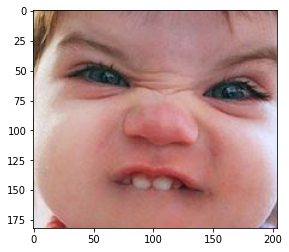

In [149]:
predict('angry.jpg')

happy


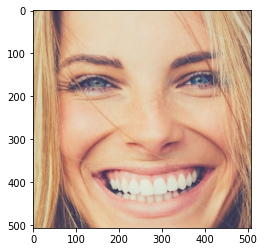

In [150]:
predict('happy_face.jpg')

surprise


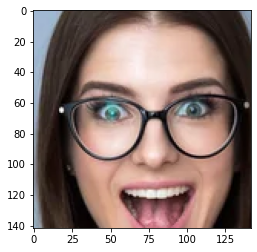

In [151]:
predict("surprised.jpg")

In [152]:
model.save("face_expression_model.hd5")

INFO:tensorflow:Assets written to: face_expression_model.hd5/assets
